In [58]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import itertools
import xgboost as xgb
import regex as re
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint, EarlyStopping
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import sklearn.preprocessing as prep
from keras.layers.recurrent import GRU
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
%matplotlib inline

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Loading Dataset

In [59]:
data = pd.read_csv('data.csv')

In [60]:
data.head()

,date,stock_id,open,high,low,average,close,volume,quantity,change %,...,max_7_days,min_7_days,ratio_overall_prev,change_daily_prev,profitability_daily_prev,ratio_7_days_prev,prevopen_1,returnsOpenPrevRaw1,prevopen_7,returnsOpenPrevRaw_7
0,1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-01-10,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,...,NaN,NaN,0.075618,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,1997-01-11,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,...,NaN,NaN,0.075618,NaN,0.0,NaN,1070.0,0.0,NaN,NaN
3,1997-01-12,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,...,NaN,NaN,0.075618,0.0,0.0,NaN,1070.0,0.0,NaN,NaN
4,1997-01-13,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,...,NaN,NaN,0.075618,0.0,0.0,NaN,1070.0,0.0,NaN,NaN


### ARIMA for ALK

In [61]:
dataset = data[data.stock_id == 'ALK']

In [62]:
dataset.head()

,date,stock_id,open,high,low,average,close,volume,quantity,change %,...,max_7_days,min_7_days,ratio_overall_prev,change_daily_prev,profitability_daily_prev,ratio_7_days_prev,prevopen_1,returnsOpenPrevRaw1,prevopen_7,returnsOpenPrevRaw_7
0,1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-01-10,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,...,NaN,NaN,0.075618,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,1997-01-11,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,...,NaN,NaN,0.075618,NaN,0.0,NaN,1070.0,0.0,NaN,NaN
3,1997-01-12,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,...,NaN,NaN,0.075618,0.0,0.0,NaN,1070.0,0.0,NaN,NaN
4,1997-01-13,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,...,NaN,NaN,0.075618,0.0,0.0,NaN,1070.0,0.0,NaN,NaN


In [63]:
# drop columns we don't want to predict
to_drop = ['stock_id', 'open', 'high', 'low', 'average', 'volume', 'quantity', 'change %', 'volume total']
dataset.drop(to_drop, axis=1, inplace=True)
print(dataset.head())

         date   close  sale_year  sale_month  sale_week  sale_day  \
0  1997-01-09  1070.0       1997           1          2         9   
1  1997-01-10  1070.0       1997           1          2        10   
2  1997-01-11  1070.0       1997           1          2        11   
3  1997-01-12  1070.0       1997           1          2        12   
4  1997-01-13  1070.0       1997           1          3        13   

   sale_dayofweek  sale_dayofyear  is_month_end  is_month_start  ...  \
0               3               9         False           False  ...   
1               4              10         False           False  ...   
2               5              11         False           False  ...   
3               6              12         False           False  ...   
4               0              13         False           False  ...   

   max_7_days  min_7_days  ratio_overall_prev  change_daily_prev  \
0         NaN         NaN                 NaN                NaN   
1         NaN   

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [64]:
dataset.head()

,date,close,sale_year,sale_month,sale_week,sale_day,sale_dayofweek,sale_dayofyear,is_month_end,is_month_start,...,max_7_days,min_7_days,ratio_overall_prev,change_daily_prev,profitability_daily_prev,ratio_7_days_prev,prevopen_1,returnsOpenPrevRaw1,prevopen_7,returnsOpenPrevRaw_7
0,1997-01-09,1070.0,1997,1,2,9,3,9,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-01-10,1070.0,1997,1,2,10,4,10,False,False,...,NaN,NaN,0.075618,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,1997-01-11,1070.0,1997,1,2,11,5,11,False,False,...,NaN,NaN,0.075618,NaN,0.0,NaN,1070.0,0.0,NaN,NaN
3,1997-01-12,1070.0,1997,1,2,12,6,12,False,False,...,NaN,NaN,0.075618,0.0,0.0,NaN,1070.0,0.0,NaN,NaN
4,1997-01-13,1070.0,1997,1,3,13,0,13,False,False,...,NaN,NaN,0.075618,0.0,0.0,NaN,1070.0,0.0,NaN,NaN


In [65]:
dataset.dropna(inplace = True)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [66]:
series = dataset[['date',
                  'close']]

In [68]:
series['date'] = pd.to_datetime(series['date'])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [69]:
series.set_index('date', inplace=True)

In [70]:
# fit model
model = ARIMA(series, order=(5,1,0))


C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [71]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 8621
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -50766.390
Method:                       css-mle   S.D. of innovations             87.335
Date:                Sun, 13 Sep 2020   AIC                         101546.780
Time:                        13:54:19   BIC                         101596.214
Sample:                    01-18-1997   HQIC                        101563.637
                         - 08-25-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2957      1.014      1.278      0.201      -0.691       3.282
ar.L1.D.close     0.0679      0.011      6.308      0.000       0.047       0.089
ar.L2.D.close     0.0100      0.011     

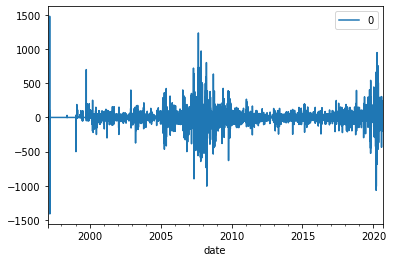

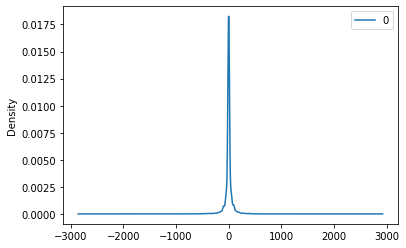

                 0
count  8621.000000
mean     -0.001116
std      87.339923
min   -1412.193628
25%      -4.585444
50%      -1.202458
75%       2.869132
max    1478.797542


In [72]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [73]:
#Rolling forecast model ARIMA 

predicted=3948.771780, expected=3950.000000
predicted=3950.146089, expected=3950.000000
predicted=3950.888757, expected=3950.000000
predicted=3950.952276, expected=3950.000000
predicted=3951.696422, expected=3950.000000
predicted=3950.506764, expected=3950.000000
predicted=3950.506676, expected=3950.000000
predicted=3950.506697, expected=3950.000000
predicted=3950.506496, expected=3961.000000
predicted=3962.373743, expected=3961.000000
predicted=3961.762644, expected=3961.000000
predicted=3961.253421, expected=3961.000000
predicted=3961.426908, expected=3961.000000
predicted=3960.854521, expected=3961.000000
predicted=3961.507875, expected=3980.000000
predicted=3982.005896, expected=4000.000000
predicted=4002.527149, expected=4000.000000
predicted=4000.535558, expected=4000.000000
predicted=3999.910455, expected=3970.000000
predicted=3966.872170, expected=3961.000000
predicted=3958.917828, expected=3961.000000
predicted=3961.996462, expected=3980.000000
predicted=3982.436793, expected=

predicted=4351.422167, expected=4400.000000
predicted=4404.521188, expected=4400.000000
predicted=4402.019000, expected=4450.000000
predicted=4454.564825, expected=4450.000000
predicted=4451.898330, expected=4450.000000
predicted=4446.590174, expected=4400.000000
predicted=4396.303665, expected=4400.000000
predicted=4396.444897, expected=4450.000000
predicted=4455.599223, expected=4501.000000
predicted=4507.076003, expected=4550.000000
predicted=4557.402795, expected=4550.000000
predicted=4550.174969, expected=4550.000000
predicted=4546.118205, expected=4510.000000
predicted=4504.070802, expected=4415.000000
predicted=4404.338947, expected=4450.000000
predicted=4452.026615, expected=4500.000000
predicted=4507.759793, expected=4500.000000
predicted=4504.036809, expected=4500.000000
predicted=4504.811221, expected=4500.000000
predicted=4498.117921, expected=4500.000000
predicted=4497.612899, expected=4560.000000
predicted=4565.259748, expected=4560.000000
predicted=4561.965742, expected=

predicted=4261.692300, expected=4262.000000
predicted=4260.360774, expected=4261.000000
predicted=4260.796412, expected=4261.000000
predicted=4261.503830, expected=4262.000000
predicted=4262.628857, expected=4265.000000
predicted=4265.791589, expected=4265.000000
predicted=4265.633890, expected=4265.000000
predicted=4265.448908, expected=4261.000000
predicted=4261.133528, expected=4261.000000
predicted=4261.257280, expected=4261.000000
predicted=4261.620871, expected=4260.000000
predicted=4260.480815, expected=4205.000000
predicted=4201.469586, expected=4205.000000
predicted=4204.253632, expected=4205.000000
predicted=4206.820765, expected=4205.000000
predicted=4206.016158, expected=4210.000000
predicted=4214.172418, expected=4221.000000
predicted=4222.488971, expected=4220.000000
predicted=4220.581545, expected=4150.000000
predicted=4144.761097, expected=4150.000000
predicted=4148.509369, expected=4150.000000
predicted=4151.512153, expected=4200.000000
predicted=4205.008295, expected=

predicted=4500.549871, expected=4500.000000
predicted=4500.549778, expected=4500.000000
predicted=4500.549689, expected=4520.000000
predicted=4522.091907, expected=4500.000000
predicted=4499.477758, expected=4500.000000
predicted=4499.613025, expected=4520.000000
predicted=4522.400383, expected=4550.000000
predicted=4552.304962, expected=4550.000000
predicted=4551.976080, expected=4550.000000
predicted=4549.693187, expected=4550.000000
predicted=4549.129878, expected=4500.000000
predicted=4494.918646, expected=4600.000000
predicted=4607.082830, expected=4595.000000
predicted=4598.690038, expected=4640.000000
predicted=4641.960115, expected=4640.000000
predicted=4643.908491, expected=4640.000000
predicted=4633.618815, expected=4700.000000
predicted=4705.121163, expected=4650.000000
predicted=4645.479382, expected=4600.000000
predicted=4594.147659, expected=4600.000000
predicted=4600.080411, expected=4600.000000
predicted=4598.587113, expected=4600.000000
predicted=4603.932311, expected=

predicted=4401.571917, expected=4400.000000
predicted=4400.489550, expected=4410.000000
predicted=4411.241484, expected=4410.000000
predicted=4410.825602, expected=4410.000000
predicted=4410.235362, expected=4410.000000
predicted=4410.495600, expected=4402.000000
predicted=4401.324014, expected=4403.000000
predicted=4403.409606, expected=4410.000000
predicted=4411.262140, expected=4410.000000
predicted=4410.725156, expected=4410.000000
predicted=4410.817075, expected=4410.000000
predicted=4410.402888, expected=4403.000000
predicted=4402.575812, expected=4401.000000
predicted=4401.204166, expected=4402.000000
predicted=4402.711908, expected=4410.000000
predicted=4411.256357, expected=4405.000000
predicted=4405.728304, expected=4405.000000
predicted=4405.324184, expected=4405.000000
predicted=4405.510026, expected=4411.000000
predicted=4411.546664, expected=4450.000000
predicted=4453.919259, expected=4411.000000
predicted=4409.320623, expected=4411.000000
predicted=4409.651723, expected=

predicted=5378.307999, expected=5360.000000
predicted=5358.064084, expected=5360.000000
predicted=5360.304024, expected=5360.000000
predicted=5360.986411, expected=5300.000000
predicted=5296.333730, expected=5300.000000
predicted=5300.144651, expected=5300.000000
predicted=5301.986703, expected=5250.000000
predicted=5247.488376, expected=5200.000000
predicted=5199.305326, expected=5150.000000
predicted=5146.874650, expected=5100.000000
predicted=5097.324890, expected=5100.000000
predicted=5103.982661, expected=5100.000000
predicted=5105.138408, expected=5100.000000
predicted=5104.017774, expected=5100.000000
predicted=5103.552383, expected=5000.000000
predicted=4993.169268, expected=5050.000000
predicted=5051.998106, expected=5100.000000
predicted=5107.701277, expected=5051.000000
predicted=5048.935350, expected=5051.000000
predicted=5054.779578, expected=5051.000000
predicted=5049.285589, expected=5100.000000
predicted=5101.757775, expected=5056.000000
predicted=5057.346625, expected=

predicted=4912.751930, expected=4912.000000
predicted=4912.321847, expected=4949.000000
predicted=4952.088274, expected=4920.000000
predicted=4918.695042, expected=4920.000000
predicted=4919.064850, expected=4950.000000
predicted=4953.083002, expected=4940.000000
predicted=4938.629954, expected=4940.000000
predicted=4941.366452, expected=4940.000000
predicted=4940.507800, expected=4940.000000
predicted=4938.904955, expected=4980.000000
predicted=4984.111502, expected=4960.000000
predicted=4960.019953, expected=4976.000000
predicted=4976.392968, expected=4977.000000
predicted=4978.084200, expected=4977.000000
predicted=4975.083347, expected=4977.000000
predicted=4978.571865, expected=4995.000000
predicted=4995.955819, expected=4970.000000
predicted=4969.087392, expected=4970.000000
predicted=4969.592026, expected=4985.000000
predicted=4987.071151, expected=5000.000000
predicted=5001.212130, expected=5000.000000
predicted=5002.052773, expected=5000.000000
predicted=5000.096379, expected=

predicted=5354.205464, expected=5305.000000
predicted=5303.433523, expected=5305.000000
predicted=5303.464950, expected=5305.000000
predicted=5306.106976, expected=5330.000000
predicted=5329.968641, expected=5301.000000
predicted=5302.716683, expected=5301.000000
predicted=5300.379077, expected=5320.000000
predicted=5322.414065, expected=5300.000000
predicted=5298.384827, expected=5300.000000
predicted=5301.424385, expected=5300.000000
predicted=5300.880632, expected=5299.000000
predicted=5298.601682, expected=5220.000000
predicted=5215.999153, expected=5220.000000
predicted=5218.808187, expected=5200.000000
predicted=5200.922844, expected=5200.000000
predicted=5200.916914, expected=5200.000000
predicted=5205.685389, expected=5200.000000
predicted=5200.775355, expected=5299.000000
predicted=5307.982512, expected=5299.000000
predicted=5301.877210, expected=5300.000000
predicted=5298.453410, expected=5220.000000
predicted=5213.887438, expected=5300.000000
predicted=5298.734618, expected=

predicted=5372.898281, expected=5399.000000
predicted=5402.006785, expected=5399.000000
predicted=5399.778698, expected=5399.000000
predicted=5398.749828, expected=5399.000000
predicted=5398.291209, expected=5361.000000
predicted=5357.217524, expected=5371.000000
predicted=5371.442116, expected=5400.000000
predicted=5403.781244, expected=5400.000000
predicted=5401.398125, expected=5450.000000
predicted=5455.698492, expected=5450.000000
predicted=5450.913204, expected=5450.000000
predicted=5447.781826, expected=5430.000000
predicted=5428.706686, expected=5450.000000
predicted=5448.652310, expected=5490.000000
predicted=5494.411110, expected=5450.000000
predicted=5448.388072, expected=5450.000000
predicted=5449.775430, expected=5450.000000
predicted=5449.970341, expected=5450.000000
predicted=5448.631680, expected=5460.000000
predicted=5463.679626, expected=5460.000000
predicted=5460.842816, expected=5489.000000
predicted=5491.478262, expected=5470.000000
predicted=5469.823304, expected=

predicted=5698.039077, expected=5702.000000
predicted=5702.773558, expected=5710.000000
predicted=5711.248662, expected=5705.000000
predicted=5705.416400, expected=5715.000000
predicted=5716.026362, expected=5715.000000
predicted=5715.789405, expected=5715.000000
predicted=5714.978037, expected=5750.000000
predicted=5753.331095, expected=5760.000000
predicted=5761.576673, expected=5771.000000
predicted=5771.854856, expected=5850.000000
predicted=5855.981446, expected=5900.000000
predicted=5903.657934, expected=5900.000000
predicted=5899.329325, expected=5900.000000
predicted=5898.147778, expected=5900.000000
predicted=5895.548400, expected=5800.000000
predicted=5790.567388, expected=5800.000000
predicted=5798.312520, expected=5790.000000
predicted=5792.212464, expected=5790.000000
predicted=5791.327799, expected=5790.000000
predicted=5796.775049, expected=5790.000000
predicted=5790.733303, expected=5790.000000
predicted=5791.231703, expected=5760.000000
predicted=5758.500878, expected=

predicted=7489.553333, expected=7500.000000
predicted=7496.421720, expected=7420.000000
predicted=7410.079918, expected=7285.000000
predicted=7279.747757, expected=7175.000000
predicted=7166.158288, expected=7200.000000
predicted=7203.681090, expected=7257.000000
predicted=7270.896822, expected=7257.000000
predicted=7267.401297, expected=7257.000000
predicted=7262.684802, expected=7300.000000
predicted=7302.055930, expected=7450.000000
predicted=7459.687518, expected=7450.000000
predicted=7453.489990, expected=7450.000000
predicted=7447.138483, expected=7456.000000
predicted=7453.516024, expected=7456.000000
predicted=7448.312211, expected=7456.000000
predicted=7456.706983, expected=7550.000000
predicted=7557.759626, expected=7600.000000
predicted=7606.475445, expected=7600.000000
predicted=7599.972939, expected=7600.000000
predicted=7598.947505, expected=7600.000000
predicted=7594.999172, expected=7600.000000
predicted=7597.968918, expected=7600.000000
predicted=7600.858081, expected=

predicted=8055.290974, expected=8050.000000
predicted=8051.083401, expected=8050.000000
predicted=8047.017638, expected=8050.000000
predicted=8047.223017, expected=8050.000000
predicted=8047.972200, expected=8050.000000
predicted=8050.895608, expected=8000.000000
predicted=7997.211973, expected=7950.000000
predicted=7946.004532, expected=7999.000000
predicted=8003.422013, expected=7999.000000
predicted=8002.582778, expected=7999.000000
predicted=8001.993665, expected=7950.000000
predicted=7949.702132, expected=7900.000000
predicted=7893.274459, expected=7704.000000
predicted=7690.293046, expected=7726.000000
predicted=7725.273378, expected=7711.000000
predicted=7718.855867, expected=7711.000000
predicted=7715.353730, expected=7711.000000
predicted=7723.050196, expected=7800.000000
predicted=7806.286477, expected=7950.000000
predicted=7964.954264, expected=7950.000000
predicted=7952.482528, expected=7949.000000
predicted=7945.721467, expected=7946.000000
predicted=7940.426144, expected=

predicted=8114.195704, expected=8011.000000
predicted=8012.248659, expected=8011.000000
predicted=8006.053196, expected=8001.000000
predicted=8006.586910, expected=8001.000000
predicted=7990.975449, expected=8001.000000
predicted=8007.156566, expected=7900.000000
predicted=7893.632461, expected=8000.000000
predicted=8006.210585, expected=8005.000000
predicted=8010.875839, expected=8055.000000
predicted=8058.231897, expected=8200.000000
predicted=8217.337360, expected=8200.000000
predicted=8197.604018, expected=8200.000000
predicted=8197.005692, expected=8599.000000
predicted=8624.694204, expected=8599.000000
predicted=8601.358383, expected=8400.000000
predicted=8378.354567, expected=8300.000000
predicted=8285.851062, expected=8250.000000
predicted=8226.371353, expected=8250.000000
predicted=8253.611615, expected=8250.000000
predicted=8264.188102, expected=8300.000000
predicted=8310.685654, expected=8300.000000
predicted=8304.901819, expected=8349.000000
predicted=8352.395675, expected=

predicted=8599.995150, expected=8599.000000
predicted=8597.605461, expected=8550.000000
predicted=8547.469155, expected=8568.000000
predicted=8569.048582, expected=8595.000000
predicted=8599.325448, expected=8560.000000
predicted=8559.221297, expected=8560.000000
predicted=8562.098000, expected=8560.000000
predicted=8560.427319, expected=8501.000000
predicted=8496.591323, expected=8550.000000
predicted=8554.925716, expected=8258.000000
predicted=8241.039759, expected=8320.000000
predicted=8317.637216, expected=8320.000000
predicted=8331.663869, expected=8320.000000
predicted=8319.511126, expected=8320.000000
predicted=8336.687190, expected=8320.000000
predicted=8317.420318, expected=8300.000000
predicted=8299.506276, expected=8300.000000
predicted=8300.408478, expected=8300.000000
predicted=8301.327002, expected=8505.000000
predicted=8520.266476, expected=8505.000000
predicted=8511.949143, expected=8505.000000
predicted=8501.394579, expected=8600.000000
predicted=8605.556170, expected=

predicted=11129.881020, expected=11010.000000
predicted=11014.936796, expected=10550.000000
predicted=10528.796856, expected=10550.000000
predicted=10541.358444, expected=10550.000000
predicted=10544.256310, expected=10000.000000
predicted=9968.212609, expected=10500.000000
predicted=10548.835636, expected=10500.000000
predicted=10520.177478, expected=11010.000000
predicted=11039.510092, expected=11000.000000
predicted=11042.159806, expected=11000.000000
predicted=10962.448505, expected=11000.000000
predicted=10997.212528, expected=10990.000000
predicted=10961.871589, expected=11050.000000
predicted=11055.407537, expected=11150.000000
predicted=11159.590374, expected=11050.000000
predicted=11046.267687, expected=11150.000000
predicted=11153.121865, expected=11150.000000
predicted=11151.696988, expected=11150.000000
predicted=11144.549953, expected=11100.000000
predicted=11102.674299, expected=11100.000000
predicted=11094.274395, expected=11150.000000
predicted=11155.438230, expected=11

predicted=11033.021927, expected=11005.000000
predicted=11009.124283, expected=11005.000000
predicted=11004.172392, expected=11001.000000
predicted=11001.931376, expected=11100.000000
predicted=11107.578837, expected=11100.000000
predicted=11102.295207, expected=11100.000000
predicted=11103.000897, expected=11100.000000
predicted=11102.808587, expected=11100.000000
predicted=11096.504599, expected=11135.000000
predicted=11138.389834, expected=10800.000000
predicted=10779.814495, expected=11000.000000
predicted=11009.403963, expected=11340.000000
predicted=11359.758294, expected=11340.000000
predicted=11342.989671, expected=11340.000000
predicted=11366.590380, expected=11896.000000
predicted=11929.173801, expected=12688.000000
predicted=12736.809049, expected=12930.000000
predicted=12972.864382, expected=12500.000000
predicted=12498.783123, expected=12500.000000
predicted=12492.992268, expected=12500.000000
predicted=12461.818760, expected=12500.000000
predicted=12481.073910, expected=1

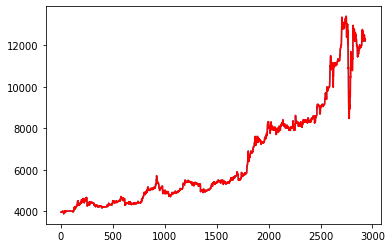

In [57]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()